In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init

In [2]:
f_rnd = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5")
f_3prong = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5")
f_purebkg = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_background.h5")

In [3]:
f_BB1 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5")
f_BB2 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5")
f_BB3 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5")


In [317]:
dt = f_BB3.values

In [318]:
correct = (dt[:,3]>0) &(dt[:,19]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]
    
for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])
        
        
correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]

In [319]:
bb_mass = dt[:,0]

In [133]:
dt_rnd = f_rnd.values

In [134]:
rnd_idx = dt_rnd[:,-1]

In [135]:
#improve purity of trainig by only selecting properly reconstructed jets 

(array([1.2068e+04, 8.5690e+03, 4.3270e+03, 1.3555e+04, 5.8502e+04,
        2.4730e+03, 3.9300e+02, 8.6000e+01, 2.0000e+01, 7.0000e+00]),
 array([  22.78974156,  134.09720251,  245.40466346,  356.7121244 ,
         468.01958535,  579.3270463 ,  690.63450724,  801.94196819,
         913.24942914, 1024.55689008, 1135.86435103]),
 <a list of 10 Patch objects>)

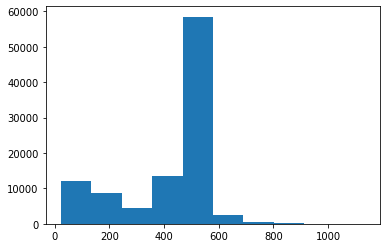

In [136]:
plt.hist(dt_rnd[rnd_idx==1,3])

# APPLY PRESELECTION BEFORE DOING THE FIT TO THE LDA

In [137]:
np.finfo(np.float32).max

3.4028235e+38

In [320]:
bkgloss_0 = np.load(f'../data_strings/bkgae_rndbkg_loss_bb1.npy')
sigaeloss_0 = np.load(f'../data_strings/sigae_2prong_loss_bb1.npy')

In [139]:
def generate_X(whichsample):
    #bkgloss_0 = np.load(f'../data_strings/bkgae_rndbkg_loss_{whichsample}.npy')
    bkgloss_1 = np.load(f'../data_strings/bkgae_purebkg_withmass_turnonselection_loss_{whichsample}.npy')
    sigaeloss_0 = np.load(f'../data_strings/sigae_2prong_loss_{whichsample}.npy')
    sigaeloss_1 = np.load(f'../data_strings/sigae_3prong_loss_{whichsample}.npy')
    
    sigaeloss_0[sigaeloss_0 > 2000 ] = 2000
    sigaeloss_1[sigaeloss_1 > 2000 ] = 2000
    
    #print(np.max(bkgloss_0))
    print(np.max(bkgloss_1))
    print(np.max(sigaeloss_0))
    print(np.max(sigaeloss_1))
    
    
    return np.column_stack((bkgloss_1,sigaeloss_0,sigaeloss_1))

In [140]:
X = np.vstack((generate_X('rndbkg'),generate_X('purebkg'),generate_X('2prong'),generate_X('3prong')))

240.18195
2000.0
2000.0
416.05627
2000.0
2000.0
114.20645
681.58276
688.8147
27.536114
179.0274
171.56403


In [141]:
X.shape

(1984842, 3)

In [27]:
def get_len(whichsample):
    bkgloss_0 = np.load(f'../data_strings/bkgae_{whichsample}_loss_rndbkg.npy')
    bkgloss_1 = np.load(f'../data_strings/bkgae_{whichsample}_loss_purebkg.npy')
    sigaeloss_0 = np.load(f'../data_strings/sigae_2prong_loss_2prong.npy')
    sigaeloss_1 = np.load(f'../data_strings/sigae_2prong_loss_3prong.npy')
    return len(bkgloss_0), len(bkgloss_1), len(sigaeloss_0), len(sigaeloss_1)

In [28]:
get_len('rndbkg')

(999913, 999916, 57042, 58822)

In [29]:
y_rndbkg  = np.zeros(938331)
y_purebkg = np.zeros(930647)
y_2prong  = np.ones(57042)
y_3prong  = np.ones(58822)
Y = np.concatenate((y_rndbkg,y_purebkg,y_2prong,y_3prong),axis=0)

In [30]:
Y.shape

(1984842,)

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [32]:
clf = QuadraticDiscriminantAnalysis()

In [33]:
clf.fit(X, Y)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [321]:
BB1 = generate_X('bb3')

146.45816
2000.0
2000.0


In [322]:
BB1.shape

(938250, 3)

In [323]:
BB1_prob = clf.predict_proba(BB1)

NameError: name 'clf' is not defined

In [324]:
bb1_index = np.where(BB1_prob[:,1]>0.91)[0]

NameError: name 'BB1_prob' is not defined

In [337]:
bb1_index = np.where((BB1[:,0]>1.4) & (BB1[:,1]<5) & (BB1[:,2]<5) & ((dt[:,13]>0.6)))[0]

In [338]:
len(bb1_index)

786

In [339]:
bb1_index;

(array([37., 40., 56., 59., 43., 48., 43., 33., 50., 46., 34., 33., 32.,
       26., 22., 24., 22.,  9.,  6., 13.,  7.,  6.,  4.,  3.,  3.,  5.,
        1.,  2.,  4.,  0.]), array([2600., 2750., 2900., 3050., 3200., 3350., 3500., 3650., 3800.,
       3950., 4100., 4250., 4400., 4550., 4700., 4850., 5000., 5150.,
       5300., 5450., 5600., 5750., 5900., 6050., 6200., 6350., 6500.,
       6650., 6800., 6950., 7100.]), <a list of 30 Patch objects>)


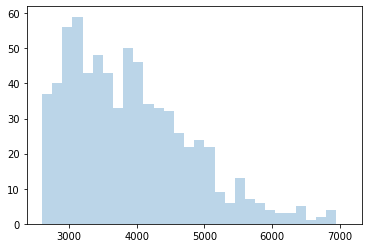

In [340]:
a = plt.hist(bb_mass[bb1_index],bins=np.linspace(2600,7100,31),alpha=0.3)
#plt.axvline(x=3823)
print(a)

NameError: name 'bins' is not defined

In [49]:
from scipy.stats import percentileofscore

In [52]:
percentiles = [percentileofscore(BB1[:,2], i) for i in BB1[:,2]]

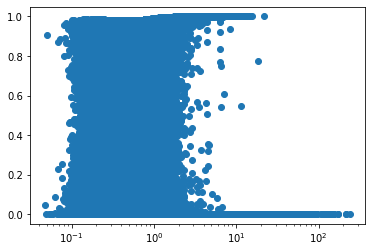

In [51]:
plt.scatter(BB1[:,0],BB1_prob[:,1])
plt.xscale('log')

In [ ]:
def get_loss(X):
    